# 0. Импорт сторонних библиотек:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno 
import pickle
import math
import numpy as np
import geopy
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from geopy.geocoders import Nominatim

In [2]:
# Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка данных:

In [4]:
# Загружаем данные из файла ga_hits
df_hits = pd.read_csv('ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [5]:
# Выводим размерность датасета df_hits
df_hits.shape

(15726470, 11)

In [6]:
# Загружаем данные из файла ga_sessions
df_session = pd.read_csv('ga_sessions.csv')
df_session.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [7]:
# Выводим размерность датасета df_session
df_session.shape

(1860042, 18)

In [8]:
# Создаем список значений колонки event_action, которые будем считать целевыми действиями
actions = ['sub_car_claim_click',
           'sub_car_claim_submit_click',
           'sub_open_dialog_click',
           'sub_custom_question_submit_click',
           'sub_call_number_click',
           'sub_callback_submit_click',
           'sub_submit_success',
           'sub_car_request_submit_click'
          ]

In [9]:
# Добавлем поле target: 1 - действие в event_action является целевым, 0 - нет
df_hits['target'] = df_hits['event_action'].apply(lambda x: 1 if x in actions else 0)
df_hits['target'].value_counts(dropna=False)

0    15621562
1      104908
Name: target, dtype: int64

In [10]:
# Создаем датасет, где будет показано было ли совершено хотя бы 1 целевое действие в рамках каждой из сессий
df_events = df_hits.groupby(['session_id']).agg({'target': 'max'})
df_events

,target
session_id,
1000009318903347362.1632663668.1632663668,0
1000010177899156286.1635013443.1635013443,0
1000013386240115915.1635402956.1635402956,0
1000017303238376207.1623489300.1623489300,0
1000020580299877109.1624943350.1624943350,0
...,...
999960188766601545.1626816843.1626816843,0
99996598443387715.1626811203.1626811203,0
999966717128502952.1638428330.1638428330,0


In [11]:
# Выводим сколько целевых и нецелевых действий было совершено всего на основе файла ga_hits
df_events['target'].value_counts(dropna=False)

0    1683850
1      50760
Name: target, dtype: int64

In [12]:
# Добавлеляем в датасет df_session информацию из колонки df_events
df_session = df_session.merge(df_events, left_on='session_id', right_on='session_id', how='outer')
df_session.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0.0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1.0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0.0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0.0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1.0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2.0,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0.0


In [13]:
# Выводим значения из колонки target датасета df_session
df_session['target'].value_counts(dropna=False)

0.0    1683850
NaN     127776
1.0      50760
Name: target, dtype: int64

In [14]:
# Заменяем значения NaN на 0
df_session['target'] = df_session['target'].apply(lambda x: 0 if math.isnan(x) == True else x)

In [15]:
# Приводим колонку target к типу int
df_session['target'] = df_session['target'].astype(int)

In [16]:
# Выводим значения из колонки target датасета df_session
df_session['target'].value_counts(dropna=False)

0    1811626
1      50760
Name: target, dtype: int64

In [17]:
# Выбираем 50000 строк датасета, у которых target = 1
df_target_1 = df_session[df_session['target'] == 1].iloc[:50000,:]
df_target_1

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
71,9055768928391199041.1623652678.1623652678,2108460508.162365,2021-06-14,09:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x780,Chrome,Russia,Moscow,1
75,9055789093275396095.1636395007.1636395007,2108465203.16364,2021-11-08,21:10:07,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,414x736,Safari,Russia,Samara,1
78,9055794766915104430.1624305327.1624305327,2108466524.16243,2021-06-21,22:00:00,1.0,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,NaN,desktop,NaN,NaN,NaN,834x1112,Safari,Russia,Domodedovo,1
132,9056028189803556573.1630154471.1630154471,2108520872.163016,2021-08-28,15:00:00,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x915,YaBrowser,Russia,Krasnodar,1
142,9056093322981390023.1628944098.1628944098,2108536037.162894,2021-08-14,15:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,360x740,Chrome,Russia,Moscow,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848865,9004657919926675472.1629693968.1629693968,2096560299.162969,2021-08-23,07:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x846,Chrome,Russia,Sochi,1
1848869,9004684699049255593.1631183530.1631183530,2096566534.163118,2021-09-09,13:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x667,Safari,Russia,Moscow,1
1848903,9004815648305346543.1629386734.1629386734,2096597023.162938,2021-08-19,18:00:00,1.0,bByPQxmDaMXgpHeypKSM,referral,NaN,NaN,NaN,desktop,NaN,NaN,NaN,1280x720,Chrome,Russia,Moscow,1
1849000,9005346725310210031.1633132533.1633132533,2096720674.163313,2021-10-02,02:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Huawei,NaN,360x720,Chrome,Russia,Irkutsk,1


In [18]:
# Выбираем 50000 строк датасета, у которых target = 0
df_target_0 = df_session[df_session['target'] == 0].sample(frac=0.05).iloc[:50000,:]
df_target_0

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
1383179,6929838074825624787.1640122731.1640122731,1613478659.162669,2021-12-22,00:38:51,10.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Surgut,0
297583,2088887376459322425.1638388746.1638388746,486356992.163839,2021-12-01,22:59:06,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x771,Chrome,Russia,Saratov,0
998034,5210980957408964451.1638903720.1638903720,1213276050.16389,2021-12-07,22:02:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,360x640,Chrome,Russia,Moscow,0
229469,1782941458494058910.1624961437.1624961437,415123407.1624961438,2021-06-29,13:00:00,1.0,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari (in-app),Russia,Krasnodar,0
1247627,6328597852317406796.1638782541.1638782541,1473491511.163878,2021-12-06,12:22:21,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,tablet,Android,Tecno,NaN,360x820,Chrome,Russia,Cherkessk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593764,3408167008971515462.1626596933.1626596933,793525718.16266,2021-07-18,11:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,eimRuUrNhZLAYcwRrNXu,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,414x896,Safari,Russia,Vidnoye,0
159803,1468915444348334363.1635234097.1635234097,342008528.163523,2021-10-26,10:41:37,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,412x846,Chrome,Russia,Yekaterinburg,0
1170748,5982942221523550581.1637417335.1637417335,1393012288.163742,2021-11-20,17:08:55,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x800,Chrome,Russia,Izhevsk,0
1529308,7577972528406442047.1632998553.1632998553,1764384221.163301,2021-09-30,13:00:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Samsung,NaN,412x846,Chrome,Russia,Tyumen,0


In [19]:
# Создаем датасет на 100000 строк, объединяя 2 предыдущих
df = pd.concat([df_target_0, df_target_1])
df['target'].value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

In [20]:
# Удаляем строки с сессиями, информации о которых не было в файле ga_sessions 
df = df[df.geo_country.notna()]
df.shape

(99949, 19)

In [21]:
df.to_csv('ga_sessions_target.csv', index=False)

In [22]:
df1 = pd.read_csv('ga_sessions_target.csv')
df1.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,6929838074825624787.1640122731.1640122731,1.613479e+09,2021-12-22,00:38:51,10.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x780,Chrome,Russia,Surgut,0
1,2088887376459322425.1638388746.1638388746,4.863570e+08,2021-12-01,22:59:06,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x771,Chrome,Russia,Saratov,0
2,5210980957408964451.1638903720.1638903720,1.213276e+09,2021-12-07,22:02:00,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,NaN,360x640,Chrome,Russia,Moscow,0
3,1782941458494058910.1624961437.1624961437,4.151234e+08,2021-06-29,13:00:00,1.0,hTjLvqNxGggkGnxSCaTm,stories,QEejXfOCtOMFLZqIPApp,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,NaN,375x812,Safari (in-app),Russia,Krasnodar,0
4,6328597852317406796.1638782541.1638782541,1.473492e+09,2021-12-06,12:22:21,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,tablet,Android,Tecno,NaN,360x820,Chrome,Russia,Cherkessk,0


In [23]:
# Выделение выборки из датасета
# df = df_session.sample(frac=0.005)
# df

# 2. Data Preparation:

## 2.1. Data Cleaning:

In [24]:
# Выводим изначальный размер датасета
df_clean = df.copy()
df_clean.shape

(99949, 19)

### 2.1.1. Проверка на дубликаты:

In [25]:
# Выводим общее колчество задублированных строк
df_clean.duplicated().sum()

0

### 2.1.2. Проверка на пропуски:

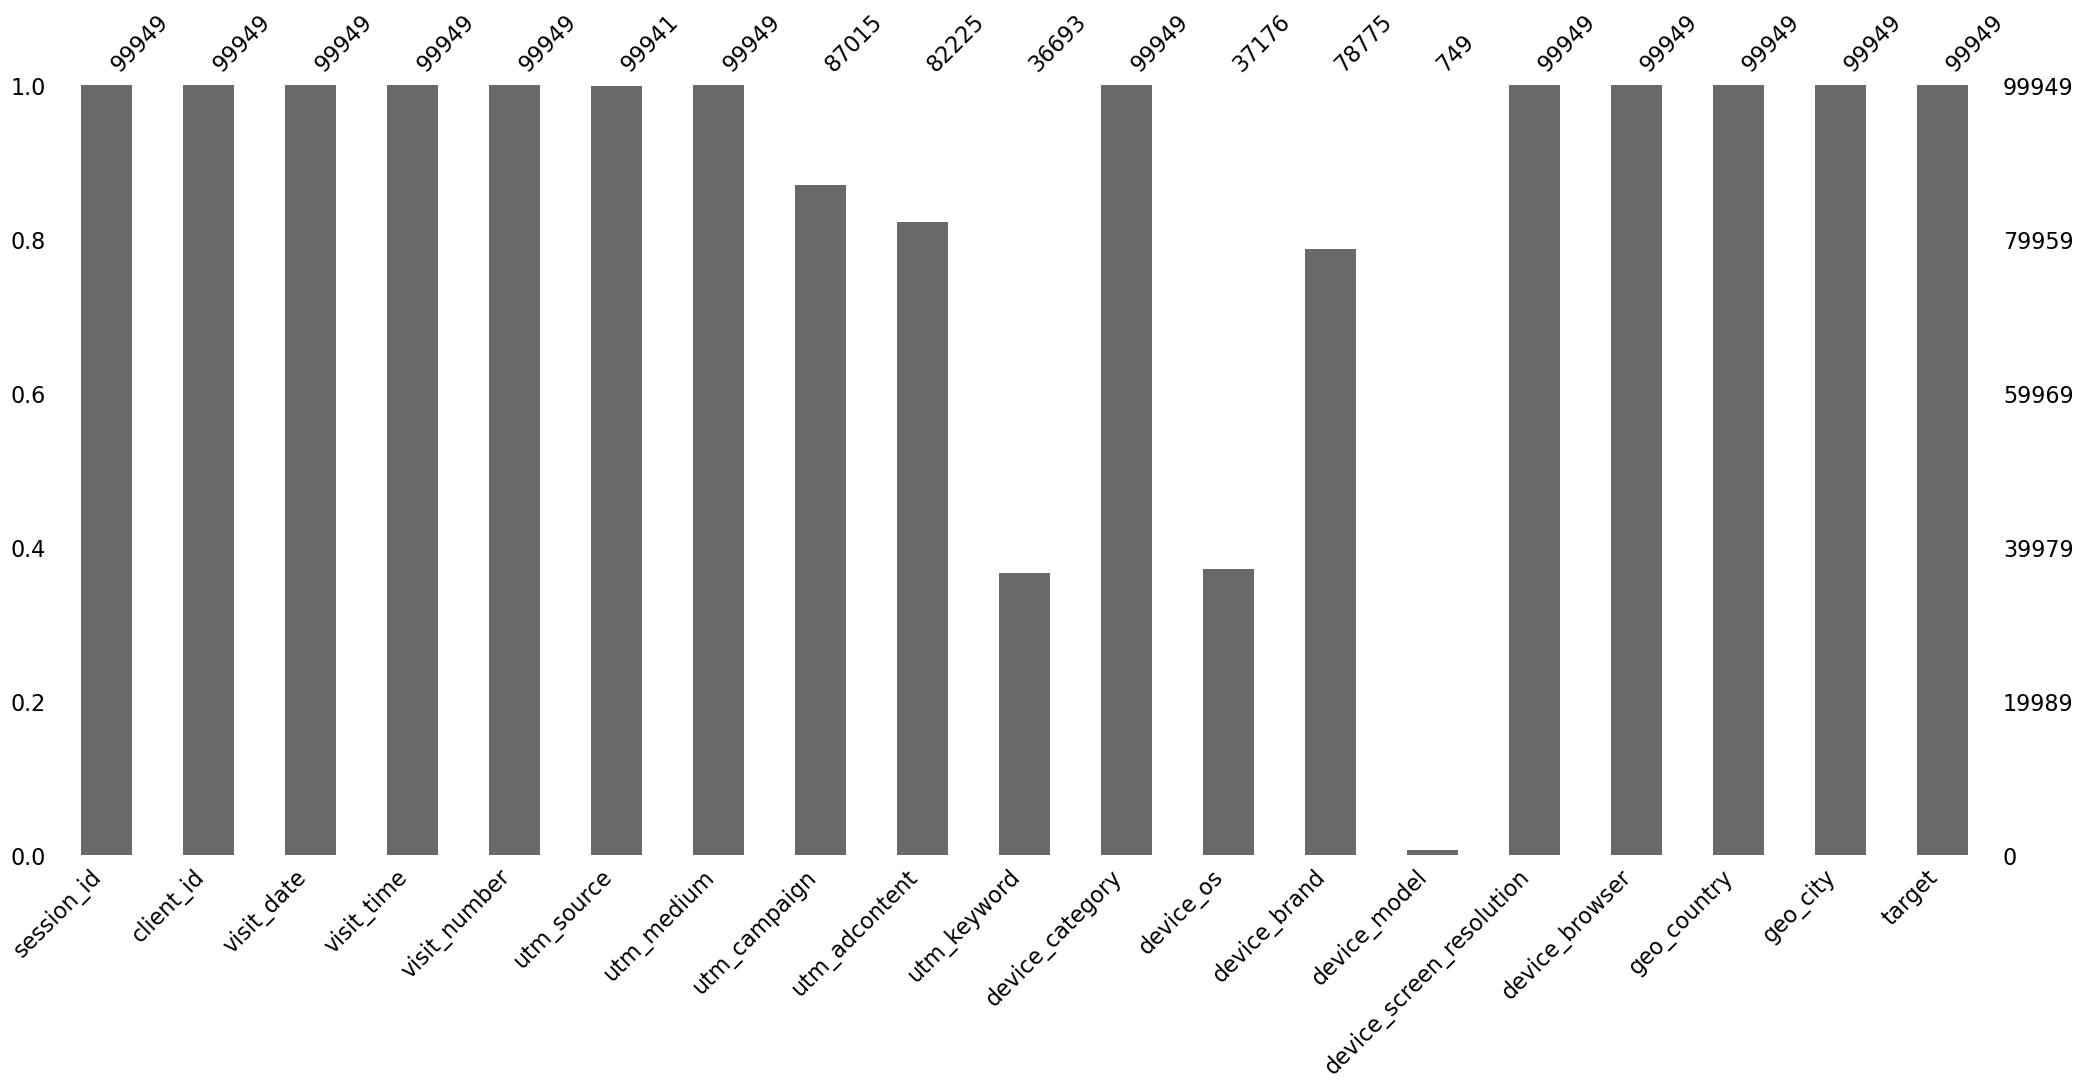

In [26]:
# Визуализируем полноту заполнения колонок
msno.bar(df_clean);

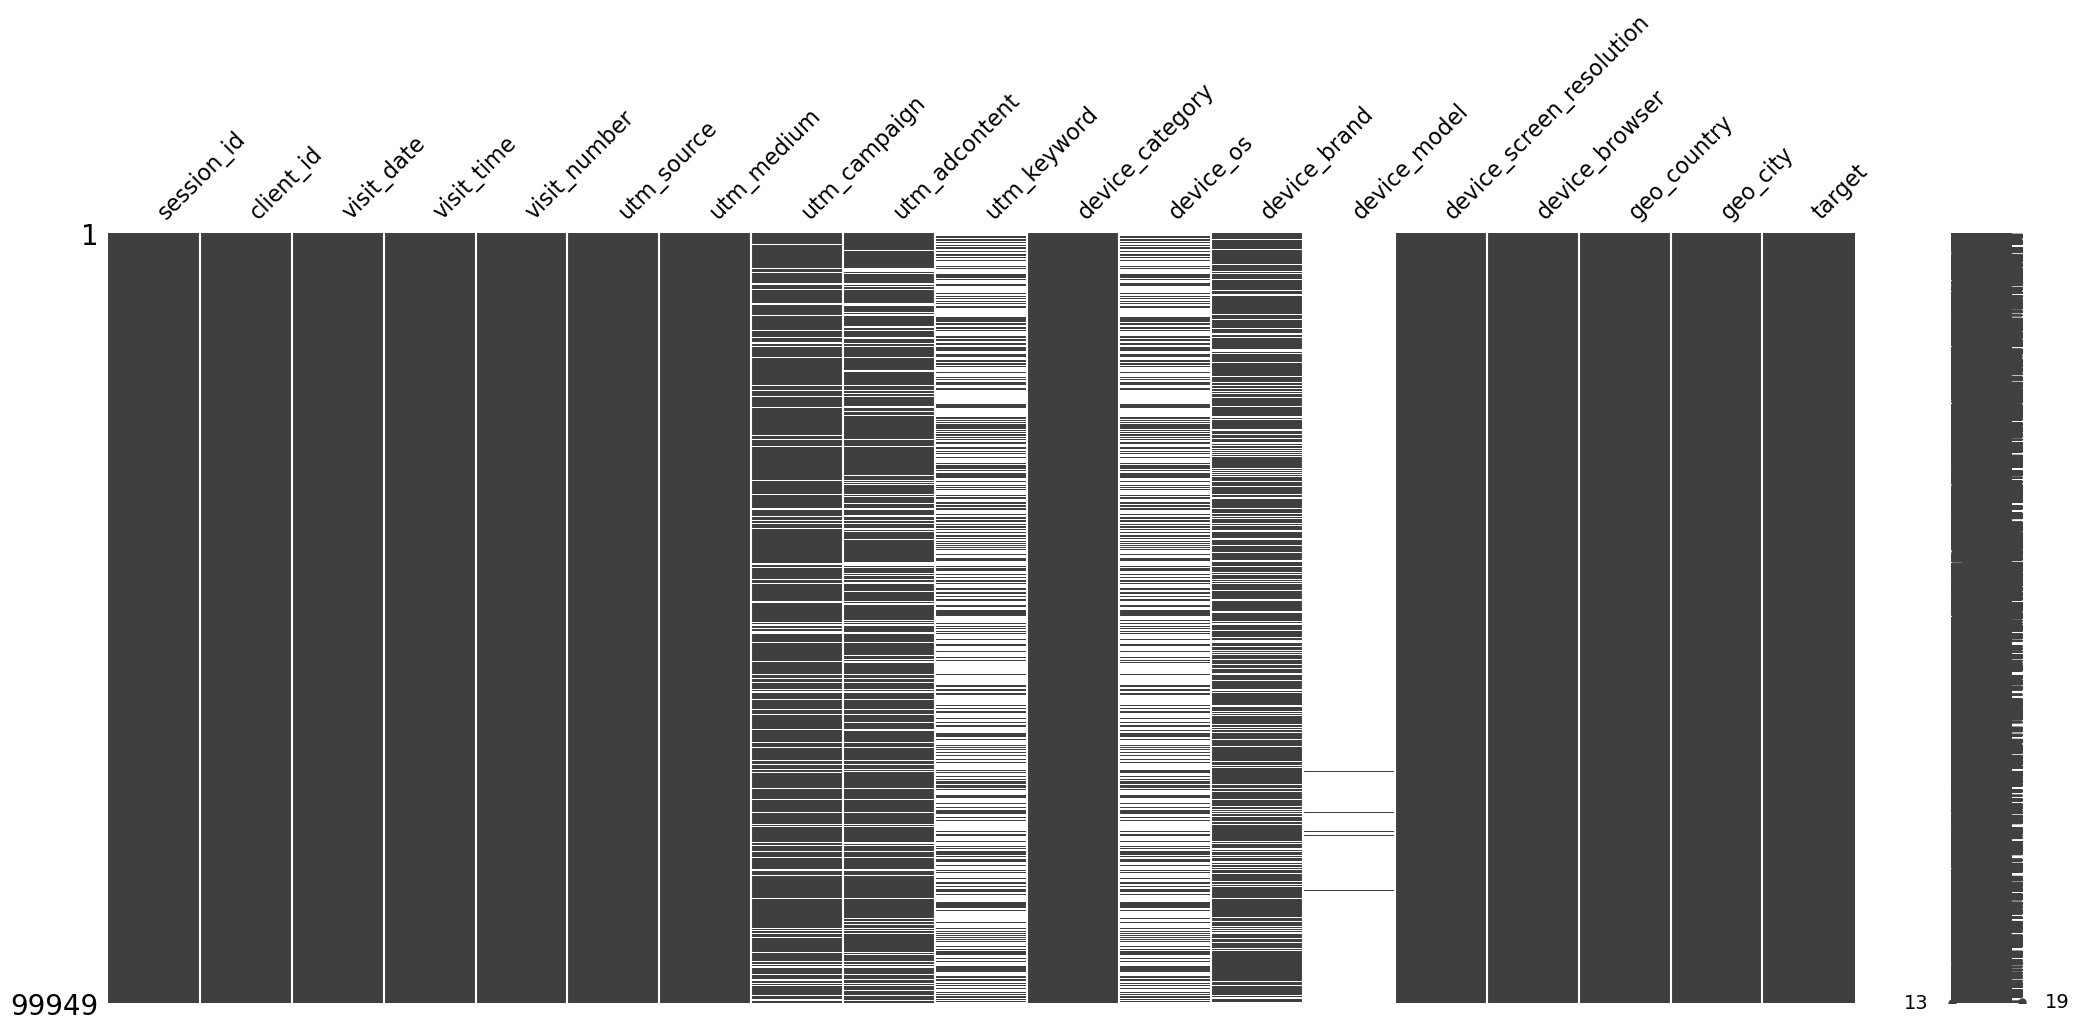

In [27]:
msno.matrix(df_clean);

In [28]:
# Функция, показывающая процент пропущенных значений в колонках
def persent_missing_values(df):
    missing_values = (round((df.isna().sum() / len(df)) * 100, 2)).sort_values(ascending=False)
    print('Процент пропущенных значений: ')
    return missing_values[missing_values.values > 0]

In [29]:
persent_missing_values(df_clean)

Процент пропущенных значений: 


device_model     99.25
utm_keyword      63.29
device_os        62.81
device_brand     21.18
utm_adcontent    17.73
utm_campaign     12.94
utm_source        0.01
dtype: float64

In [30]:
# Функция, показывающая количество и процент полностью заполненных строк
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2), '%')

In [31]:
print_useful_rows_info(df_clean)

Количество полностью заполненных объектов из всей выборки: 661
Процент полностью заполненных объектов из всей выборки: 0.66 %


### 2.1.3. Заполнение пропусков:

##### Удаление неинформативных признаков:

In [32]:
# Удаляем колонки, где пропущено более 25% значений, и колонки с id
df_clean = df_clean.drop(columns=['device_model', 'utm_keyword', 'device_os', 'session_id', 'client_id'])

In [33]:
persent_missing_values(df_clean)

Процент пропущенных значений: 


device_brand     21.18
utm_adcontent    17.73
utm_campaign     12.94
utm_source        0.01
dtype: float64

In [34]:
print_useful_rows_info(df_clean)

Количество полностью заполненных объектов из всей выборки: 65043
Процент полностью заполненных объектов из всей выборки: 65.08 %


##### Заполнение пропусков для device_brand, utm_adcontent, utm_campaign и utm_source:

In [35]:
# Замена значений '(not set)' на 'other'
df_clean['device_brand'] = df_clean['device_brand'].apply(lambda x: 'other' if x == '(not set)' else x)

In [36]:
# Составление списка колонок с пропущенными значениями
columns = ['device_brand', 'utm_adcontent', 'utm_campaign', 'utm_source']

In [37]:
# Заполнение пропусков наиболее часто встречающемся значением 
# for feat in columns:
    # df_clean[feat].fillna(df_clean[feat].mode()[0], inplace=True)

In [38]:
# Заполнение пропусков значением 'other'
for feat in columns:
    df_clean[feat].fillna(df_clean[feat].fillna('other'), inplace=True)

In [39]:
print_useful_rows_info(df_clean)

Количество полностью заполненных объектов из всей выборки: 99949
Процент полностью заполненных объектов из всей выборки: 100.0 %


### 2.1.4. Приведение типов:

In [40]:
# Вывод информации о выборке
print('Информация о выборке:\n')
df_types = df_clean.copy()
df_types.info()

Информация о выборке:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99949 entries, 1383179 to 1849007
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   visit_date                99949 non-null  object 
 1   visit_time                99949 non-null  object 
 2   visit_number              99949 non-null  float64
 3   utm_source                99949 non-null  object 
 4   utm_medium                99949 non-null  object 
 5   utm_campaign              99949 non-null  object 
 6   utm_adcontent             99949 non-null  object 
 7   device_category           99949 non-null  object 
 8   device_brand              99949 non-null  object 
 9   device_screen_resolution  99949 non-null  object 
 10  device_browser            99949 non-null  object 
 11  geo_country               99949 non-null  object 
 12  geo_city                  99949 non-null  object 
 13  target                    9994

##### Приведение visit_number к int32:

In [41]:
df_types['visit_number'].describe().apply(lambda x: f'{x:0.3f}')

count    99949.000
mean         3.588
std         19.971
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        562.000
Name: visit_number, dtype: object

In [42]:
df_types['visit_number'] = df_types['visit_number'].astype(int)
df_types['visit_number'].dtype

dtype('int32')

##### Приведение visit_date и visit_time к datetime64:

In [43]:
df_types['posting_date'] = df_types.apply(lambda x: 'T'.join([x['visit_date'], x['visit_time']]), axis=1)
df_types['posting_date']

1383179    2021-12-22T00:38:51
297583     2021-12-01T22:59:06
998034     2021-12-07T22:02:00
229469     2021-06-29T13:00:00
1247627    2021-12-06T12:22:21
                  ...         
1848865    2021-08-23T07:00:00
1848869    2021-09-09T13:00:00
1848903    2021-08-19T18:00:00
1849000    2021-10-02T02:00:00
1849007    2021-05-29T06:00:00
Name: posting_date, Length: 99949, dtype: object

In [44]:
df_types['date'] = pd.to_datetime(df_types['posting_date'], utc=True)
df_types['date']

1383179   2021-12-22 00:38:51+00:00
297583    2021-12-01 22:59:06+00:00
998034    2021-12-07 22:02:00+00:00
229469    2021-06-29 13:00:00+00:00
1247627   2021-12-06 12:22:21+00:00
                     ...           
1848865   2021-08-23 07:00:00+00:00
1848869   2021-09-09 13:00:00+00:00
1848903   2021-08-19 18:00:00+00:00
1849000   2021-10-02 02:00:00+00:00
1849007   2021-05-29 06:00:00+00:00
Name: date, Length: 99949, dtype: datetime64[ns, UTC]

In [45]:
# Удаление полей posting_date, visit_date и visit_time
df_types = df_types.drop(columns=['visit_date', 'visit_time', 'posting_date'])

### 2.1.5. Нахождение выбросов и аномалий:

##### Нахождение и удаление выбросов и аномалий для visit_number:

In [46]:
df_types['visit_number'].describe().apply(lambda x: f'{x:0.3f}')

count    99949.000
mean         3.588
std         19.971
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        562.000
Name: visit_number, dtype: object

In [47]:
# Функция нахождения границ диапазона нормальных значений
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)

    return boundaries

In [48]:
# Функция нахождения значений, выходящих за границы диапазона нормальных значений
def boundaries_result(data):
    boundaries = calculate_outliers(data)
    is_outlier = (data < boundaries[0]) | (data > boundaries[1])
    print('Границы диапазона:', boundaries)
    print('Количество значений, выходящих за границы диапазона:', is_outlier.sum())
    
boundaries_result(df_types['visit_number'])

Границы диапазона: (-0.5, 3.5)
Количество значений, выходящих за границы диапазона: 11696


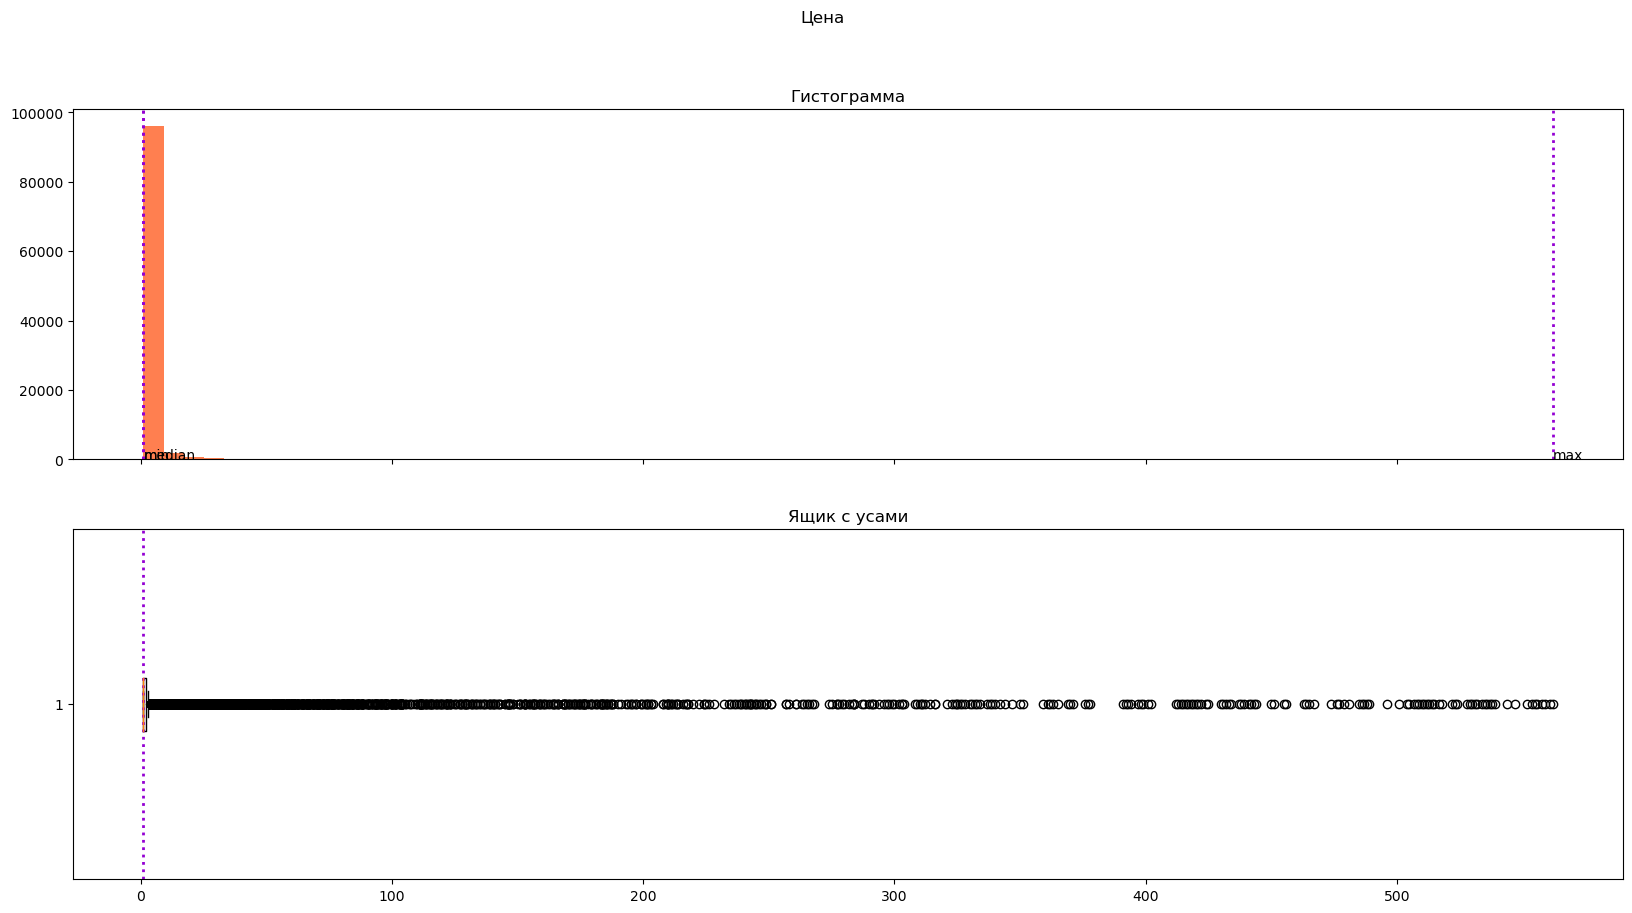

In [49]:
# Визуализация с помощью гистограммы и ящика с усами
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

ax1.hist(df_types['visit_number'], bins=70, color='coral')
ax1.set_title('Гистограмма')
ax1.axvline(df_types['visit_number'].median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.axvline(df_types['visit_number'].min(), color='darkviolet', linestyle='dotted', linewidth=2)
ax1.axvline(df_types['visit_number'].max(), color='darkviolet', linestyle='dotted', linewidth=2)

ax1.text(df_types['visit_number'].median(),-100,'median',rotation=0)
ax1.text(df_types['visit_number'].min(),-100,'min',rotation=0)
ax1.text(df_types['visit_number'].max(),-100,'max',rotation=0)

ax2.boxplot(df_types['visit_number'], vert=False)
ax2.axvline(df_types['visit_number'].median(), color='darkviolet', linestyle='dotted', linewidth=2)
ax2.set_title('Ящик с усами')

ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

fig.suptitle('Цена');

##### Замена выбросов на максимальное значение для visit_number:

In [50]:
boundaries = calculate_outliers(df_types['visit_number'])
df_types.loc[df_types['visit_number'] > boundaries[1], 'visit_number'] = int(math.ceil(boundaries[1]))
df_types['visit_number'].describe()

count    99949.000000
mean         1.591822
std          1.022922
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: visit_number, dtype: float64

## 2.2. Data Transformation:

### 2.2.1. Уменьшение количества значений для категориальных переменных:

##### Уменьшение количества значений в категориальных переменных:

In [51]:
df_types.nunique()

visit_number                    4
utm_source                    142
utm_medium                     39
utm_campaign                  293
utm_adcontent                 162
device_category                 3
device_brand                   80
device_screen_resolution      850
device_browser                 27
geo_country                    92
geo_city                      833
target                          2
date                        40618
dtype: int64

In [52]:
categorical = df_types.select_dtypes(include=['object']).columns.drop(['geo_country', 'geo_city'])
categorical

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser'],
      dtype='object')

In [53]:
for feat in categorical:
    if df_types[feat].nunique() > 10:
        feat_list = list(dict(df_types[feat].value_counts()).keys())[0:10]
        df_types[feat] = df_types[feat].apply(lambda x: x if x in feat_list else 'other')
df_types.nunique()

visit_number                    4
utm_source                     11
utm_medium                     11
utm_campaign                   10
utm_adcontent                  10
device_category                 3
device_brand                   10
device_screen_resolution       11
device_browser                 11
geo_country                    92
geo_city                      833
target                          2
date                        40618
dtype: int64

## 2.3. Data visualisation:

In [54]:
df_pivot = df_types.pivot_table(index='utm_source', columns='target', aggfunc='size')

df_pivot.iloc[0] = df_pivot.iloc[0]/df_pivot.iloc[0].sum()
df_pivot.iloc[1] = df_pivot.iloc[1]/df_pivot.iloc[1].sum()

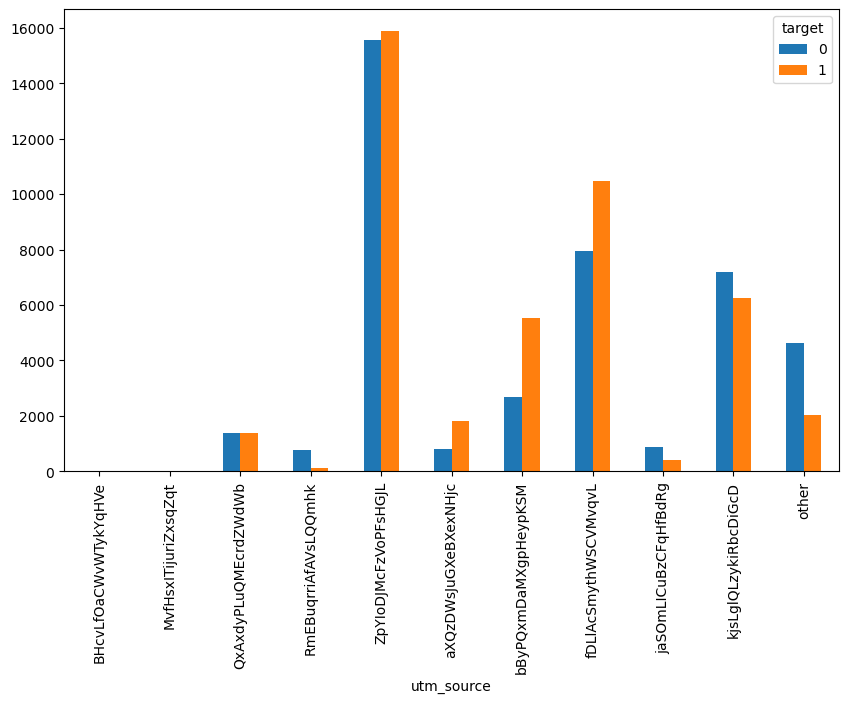

In [55]:
# Столбчатая диаграмма 
df_pivot.plot(kind='bar', figsize=(10,6))
plt.show()

In [56]:
df_pivot = df_types.pivot_table(index='utm_campaign', columns='target', aggfunc='size')

df_pivot.iloc[0] = df_pivot.iloc[0]/df_pivot.iloc[0].sum()
df_pivot.iloc[1] = df_pivot.iloc[1]/df_pivot.iloc[1].sum()

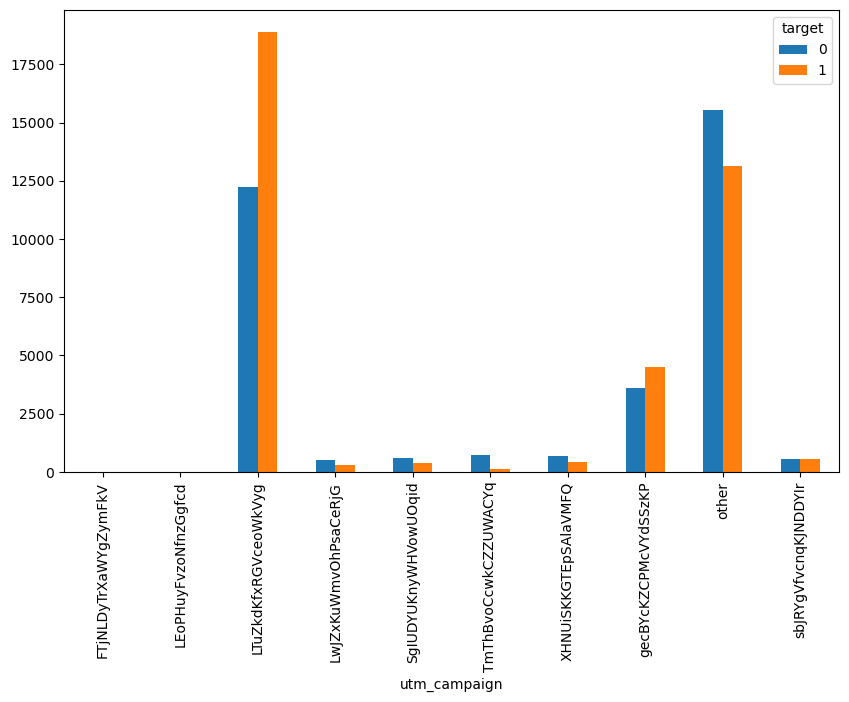

In [57]:
# Столбчатая диаграмма 
df_pivot.plot(kind='bar', figsize=(10,6))
plt.show()

In [60]:
df_pivot = df_types.pivot_table(index='device_brand', columns='target', aggfunc='size')

df_pivot.iloc[0] = df_pivot.iloc[0]/df_pivot.iloc[0].sum()
df_pivot.iloc[1] = df_pivot.iloc[1]/df_pivot.iloc[1].sum()

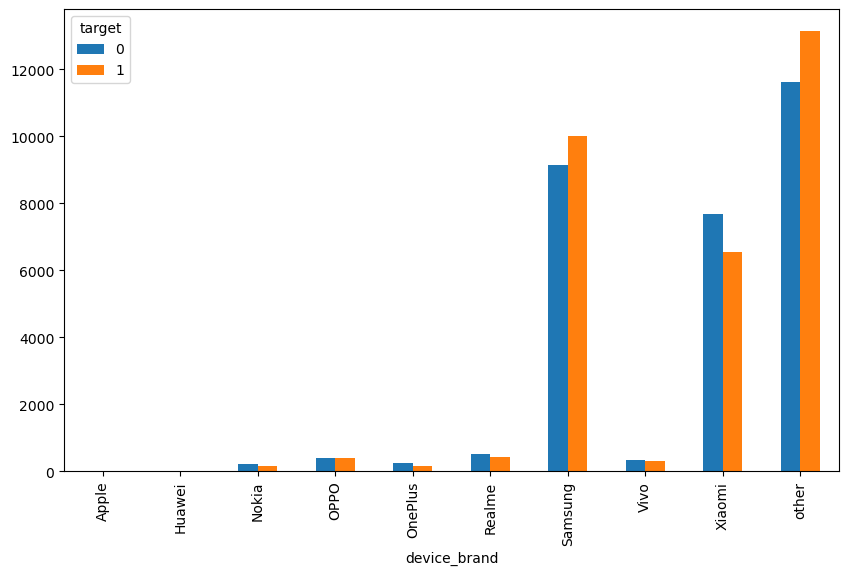

In [61]:
# Столбчатая диаграмма 
df_pivot.plot(kind='bar', figsize=(10,6))
plt.show()

## 2.4. Feature engineering:

### 2.4.1. Создание новых полей

#### Создание новых полей из date:

In [62]:
df_types['date']

1383179   2021-12-22 00:38:51+00:00
297583    2021-12-01 22:59:06+00:00
998034    2021-12-07 22:02:00+00:00
229469    2021-06-29 13:00:00+00:00
1247627   2021-12-06 12:22:21+00:00
                     ...           
1848865   2021-08-23 07:00:00+00:00
1848869   2021-09-09 13:00:00+00:00
1848903   2021-08-19 18:00:00+00:00
1849000   2021-10-02 02:00:00+00:00
1849007   2021-05-29 06:00:00+00:00
Name: date, Length: 99949, dtype: datetime64[ns, UTC]

In [63]:
df_types['date'].dt.year.value_counts()

2021    99949
Name: date, dtype: int64

In [64]:
df_types['month'] = df_types['date'].dt.month
df_types['month'].value_counts()

12    18038
10    14693
11    14474
9     12984
6     10895
7      9832
8      9826
5      9207
Name: month, dtype: int64

In [65]:
df_types['day'] = df_types['date'].dt.day
df_types['day'].value_counts()

24    6329
25    4550
21    4211
29    4078
30    3759
14    3586
26    3567
28    3556
27    3412
17    3134
16    3121
22    3109
13    3080
15    3040
12    3039
19    2990
23    2990
18    2955
1     2915
20    2906
2     2873
6     2853
11    2800
3     2766
8     2755
7     2746
5     2742
10    2721
9     2717
4     2464
31    2185
Name: day, dtype: int64

In [66]:
df_types['hour'] = df_types['date'].dt.hour
df_types['hour'].value_counts()

14    6217
16    6072
13    5987
15    5906
11    5780
12    5737
17    5678
10    5594
18    5515
19    5138
20    5027
21    5004
22    4810
9     4693
23    4289
8     3678
0     3642
7     2620
1     2205
6     1707
2     1338
5     1249
3     1060
4     1003
Name: hour, dtype: int64

### 2.4.2. Генерация дополнительных фичей с помощью lambda функций:

#### Создание новых полей из geo_country:

In [67]:
geolocator = Nominatim(user_agent="geoapiexercises")

In [68]:
# Вывод уникальных значений для geo_country
df_types['geo_country'].unique()

array(['Russia', 'Ukraine', 'Germany', 'Turkey', 'Sweden', 'Hungary',
       'United States', 'United Kingdom', 'Andorra', 'Ireland', 'Belarus',
       'Singapore', 'Austria', 'Lithuania', 'Kazakhstan', 'Uzbekistan',
       'Brazil', 'Australia', 'Moldova', 'Georgia', '(not set)',
       'Netherlands', 'Italy', 'Philippines', 'Finland', 'Cyprus',
       'Kyrgyzstan', 'Armenia', 'Seychelles', 'Afghanistan', 'Cuba',
       'United Arab Emirates', 'Czechia', 'Bulgaria', 'Romania', 'Latvia',
       'Poland', 'Luxembourg', 'Bahrain', 'Tajikistan', 'Canada',
       'Mexico', 'France', 'Spain', 'South Korea', 'Estonia',
       'Azerbaijan', 'Greece', 'Egypt', 'Mongolia', 'Israel', 'Syria',
       'Vietnam', 'India', 'Montenegro', 'Dominican Republic', 'Belgium',
       'Peru', 'Croatia', 'Thailand', 'Taiwan', 'Iran', 'Iraq',
       'Maldives', 'Bangladesh', 'Serbia', 'Indonesia', 'Saudi Arabia',
       'Qatar', 'Lebanon', 'Portugal', 'Switzerland', 'Morocco', 'Norway',
       'Sri Lanka', 'Ja

In [69]:
# Замена значений '(not set)' на наиболее часто встречающееся значение
df_types['geo_country'] = df_types['geo_country'].apply(lambda x: df_types['geo_country'].mode()[0] if x == '(not set)' else x)
df_types['geo_country'].unique()

array(['Russia', 'Ukraine', 'Germany', 'Turkey', 'Sweden', 'Hungary',
       'United States', 'United Kingdom', 'Andorra', 'Ireland', 'Belarus',
       'Singapore', 'Austria', 'Lithuania', 'Kazakhstan', 'Uzbekistan',
       'Brazil', 'Australia', 'Moldova', 'Georgia', 'Netherlands',
       'Italy', 'Philippines', 'Finland', 'Cyprus', 'Kyrgyzstan',
       'Armenia', 'Seychelles', 'Afghanistan', 'Cuba',
       'United Arab Emirates', 'Czechia', 'Bulgaria', 'Romania', 'Latvia',
       'Poland', 'Luxembourg', 'Bahrain', 'Tajikistan', 'Canada',
       'Mexico', 'France', 'Spain', 'South Korea', 'Estonia',
       'Azerbaijan', 'Greece', 'Egypt', 'Mongolia', 'Israel', 'Syria',
       'Vietnam', 'India', 'Montenegro', 'Dominican Republic', 'Belgium',
       'Peru', 'Croatia', 'Thailand', 'Taiwan', 'Iran', 'Iraq',
       'Maldives', 'Bangladesh', 'Serbia', 'Indonesia', 'Saudi Arabia',
       'Qatar', 'Lebanon', 'Portugal', 'Switzerland', 'Morocco', 'Norway',
       'Sri Lanka', 'Japan', 'Cambod

##### Создание geo_country_lat:

In [70]:
# Создание словаря значений страна: широта
geo_country_list = list(df_types['geo_country'].unique())
geo_country_dict_lat = {geo_country_list[i]: geolocator.geocode(geo_country_list[i]).latitude for i in range(len(geo_country_list))}
geo_country_dict_lat

{'Russia': 64.6863136,
 'Ukraine': 49.4871968,
 'Germany': 51.1638175,
 'Turkey': 38.9597594,
 'Sweden': 59.6749712,
 'Hungary': 47.1817585,
 'United States': 39.7837304,
 'United Kingdom': 54.7023545,
 'Andorra': 42.5407167,
 'Ireland': 52.865196,
 'Belarus': 53.4250605,
 'Singapore': 1.357107,
 'Austria': 47.59397,
 'Lithuania': 55.3500003,
 'Kazakhstan': 48.1012954,
 'Uzbekistan': 41.32373,
 'Brazil': -10.3333333,
 'Australia': -24.7761086,
 'Moldova': 47.2879608,
 'Georgia': 41.6809707,
 'Netherlands': 52.2434979,
 'Italy': 42.6384261,
 'Philippines': 12.7503486,
 'Finland': 63.2467777,
 'Cyprus': 34.9823018,
 'Kyrgyzstan': 41.5089324,
 'Armenia': 40.7696272,
 'Seychelles': -4.6574977,
 'Afghanistan': 33.7680065,
 'Cuba': 23.0131338,
 'United Arab Emirates': 24.0002488,
 'Czechia': 49.7439047,
 'Bulgaria': 42.6073975,
 'Romania': 45.9852129,
 'Latvia': 56.8406494,
 'Poland': 52.215933,
 'Luxembourg': 49.8158683,
 'Bahrain': 26.1551249,
 'Tajikistan': 38.6281733,
 'Canada': 61.06669

In [71]:
# Создание поля для значения широты для страны
df_types['geo_country_lat'] = df_types['geo_country'].apply(lambda x: geo_country_dict_lat.get(x) if x in geo_country_dict_lat.keys() else 0)
df_types.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,date,month,day,hour,geo_country_lat
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,Russia,Surgut,0,2021-12-22 00:38:51+00:00,12,22,0,64.686314
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,Russia,Saratov,0,2021-12-01 22:59:06+00:00,12,1,22,64.686314
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Moscow,0,2021-12-07 22:02:00+00:00,12,7,22,64.686314
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),Russia,Krasnodar,0,2021-06-29 13:00:00+00:00,6,29,13,64.686314
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,Russia,Cherkessk,0,2021-12-06 12:22:21+00:00,12,6,12,64.686314


##### Создание geo_country_long:

In [72]:
# Создание словаря значений страна: долгота
geo_country_dict_long = {geo_country_list[i]: geolocator.geocode(geo_country_list[i]).longitude for i in range(len(geo_country_list))}
geo_country_dict_long

{'Russia': 97.7453061,
 'Ukraine': 31.2718321,
 'Germany': 10.4478313,
 'Turkey': 34.9249653,
 'Sweden': 14.5208584,
 'Hungary': 19.5060937,
 'United States': -100.445882,
 'United Kingdom': -3.2765753,
 'Andorra': 1.5732033,
 'Ireland': -7.9794599,
 'Belarus': 27.6971358,
 'Singapore': 103.8194992,
 'Austria': 14.12456,
 'Lithuania': 23.7499997,
 'Kazakhstan': 66.7780818,
 'Uzbekistan': 63.9528098,
 'Brazil': -53.2,
 'Australia': 134.755,
 'Moldova': 28.5670941,
 'Georgia': 44.0287382,
 'Netherlands': 5.6343227,
 'Italy': 12.674297,
 'Philippines': 122.7312101,
 'Finland': 25.9209164,
 'Cyprus': 33.1451285,
 'Kyrgyzstan': 74.724091,
 'Armenia': 44.6736646,
 'Seychelles': 55.4540146,
 'Afghanistan': 66.2385139,
 'Cuba': -80.8328748,
 'United Arab Emirates': 53.9994829,
 'Czechia': 15.3381061,
 'Bulgaria': 25.4856617,
 'Romania': 24.6859225,
 'Latvia': 24.7537645,
 'Poland': 19.134422,
 'Luxembourg': 6.1296751,
 'Bahrain': 50.5344606,
 'Tajikistan': 70.8156541,
 'Canada': -107.991707,
 

In [73]:
# Создание поля для значения долготы для страны
df_types['geo_country_long'] = df_types['geo_country'].apply(lambda x: geo_country_dict_long.get(x) if x in geo_country_dict_long.keys() else 0)
df_types

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,date,month,day,hour,geo_country_lat,geo_country_long
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,Russia,Surgut,0,2021-12-22 00:38:51+00:00,12,22,0,64.686314,97.745306
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,Russia,Saratov,0,2021-12-01 22:59:06+00:00,12,1,22,64.686314,97.745306
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Moscow,0,2021-12-07 22:02:00+00:00,12,7,22,64.686314,97.745306
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),Russia,Krasnodar,0,2021-06-29 13:00:00+00:00,6,29,13,64.686314,97.745306
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,Russia,Cherkessk,0,2021-12-06 12:22:21+00:00,12,6,12,64.686314,97.745306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848865,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,other,Chrome,Russia,Sochi,1,2021-08-23 07:00:00+00:00,8,23,7,64.686314,97.745306
1848869,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,1,2021-09-09 13:00:00+00:00,9,9,13,64.686314,97.745306
1848903,1,bByPQxmDaMXgpHeypKSM,referral,other,other,desktop,other,other,Chrome,Russia,Moscow,1,2021-08-19 18:00:00+00:00,8,19,18,64.686314,97.745306
1849000,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,other,Chrome,Russia,Irkutsk,1,2021-10-02 02:00:00+00:00,10,2,2,64.686314,97.745306


#### Создание новых полей из geo_city:

In [74]:
# Вывод уникальных значений для geo_city
df_types['geo_city'].unique()

array(['Surgut', 'Saratov', 'Moscow', 'Krasnodar', 'Cherkessk',
       'Saint Petersburg', 'Oryol', 'Korolyov', 'Dolgoprudny', 'Taganrog',
       'Kazan', 'Astrakhan', 'Orenburg', 'Novomoskovsk', 'Grozny',
       'Kursk', 'Povarovo', 'Yekaterinburg', 'Naro-Fominsk',
       'Krasnogorsk', 'Zheleznodorozhny', 'Lyubertsy', "Pervomais'k",
       'Tver', 'Perm', 'Tula', '(not set)', 'Samara', 'Cheboksary',
       'Chelyabinsk', 'Reutov', 'Murmansk', 'Kotelniki', 'Izmir',
       'Krasnoyarsk', 'Vladivostok', 'Mytishchi', 'Khimki', 'Tyumen',
       'Almetyevsk', 'Novosibirsk', 'Yenakijeve', 'Nizhny Novgorod',
       'Ufa', 'Sevastopol', 'Podolsk', 'Rostov-on-Don', 'Belgorod',
       'Lulea', 'Voronezh', 'Stary Oskol', 'Lobnya', 'Odintsovo', 'Omsk',
       'Pushkino', 'Irkutsk', 'Balashikha', 'Makhachkala', 'Tosno',
       'Chita', 'Smolensk', 'Yablonovsky', 'Obninsk', 'Kostroma',
       'Voskresensk', 'Fryazino', 'Izhevsk', 'Vyshhorod',
       'Petropavlovsk-Kamchatskiy', 'Domodedovo', 'Volzh

In [117]:
incorrect_city = ['(not set)', '24130', '7668', '13403', '83709', '9992', '53425', '8756', '6784', 'Novoye Devyatkino', 'Yablonovsky',
                 'Novomikhailovskii', 'Lorenskog Municipality', 'Tuymazy', "Alchevs'k", 'Kalininets', 'Zhigulevsk', 'Zagorjanskas',
                 "Berdyans'k", "Emel'yanovo", 'Troedobelikovskiy', 'Belebey', 'Krasnoturyinsk', 'Petrovo-Dalneye', "Pervomais'k",
                 'Chusovskoye Urban Settlement', "Roven'ky", "Bilohirs'k", "Hresivs'kyi", "Krasnohvardiis'ke", "Oktyabrs'ke",
                 "Khartsyz'k", 'Veliky Ustyug', 'Dorokhovskoja', "Shakhtars'k", 'Dzhankoi', 'Sandnes Municipality', 'Тимофеевка',
                 'Artemovskiy', "Ul'yanovka", "Kup'yans'k", '8230', '39404', "Pereval's'k", "Starobil's'k", 'Chystiakove', 
                  "Armyans'k", 'Voronezjskaja', "Krasnoperekops'k", 'Zavolzhye', 'Arsenyev', "Yuzhnoukrains'k", "Dokuchajevs'k",
                 'Kresttsy', "Chornomors'ke", "Synel'nykove", "Saransk'", 'Yenakijeve', "Debal'tseve", 'Pak Phriao',
                 "Kam'yanets'-Podil's'kyi", "'s-Hertogenbosch", "Mariupol'", "Ust'-Kamenogorsk", "Sana'a", "Trostyanets'", "Uman'",
                 "Nikopol'", "Irpin'", 'Stolberg (Rhineland)', "Ovidiopol'", "Radomyshl'", 'Shlisselburg', 'Dovzhansk', "Krolevets'",
                 "Kovel'", "Industrial'nyy", "L'Hospitalet de Llobregat", "Melitopol'", "Cox's Bazar", 'Dobropillya', 'Lyubotyn']

In [118]:
# Замена некорректных значений на наиболее часто встречающееся значение
df_types['geo_city'] = df_types['geo_city'].apply(lambda x: df_types['geo_city'].mode()[0] if x in incorrect_city else x)
df_types['geo_city'].unique()

array(['Surgut', 'Saratov', 'Moscow', 'Krasnodar', 'Cherkessk',
       'Saint Petersburg', 'Oryol', 'Korolyov', 'Dolgoprudny', 'Taganrog',
       'Kazan', 'Astrakhan', 'Orenburg', 'Novomoskovsk', 'Grozny',
       'Kursk', 'Povarovo', 'Yekaterinburg', 'Naro-Fominsk',
       'Krasnogorsk', 'Zheleznodorozhny', 'Lyubertsy', 'Tver', 'Perm',
       'Tula', 'Samara', 'Cheboksary', 'Chelyabinsk', 'Reutov',
       'Murmansk', 'Kotelniki', 'Izmir', 'Krasnoyarsk', 'Vladivostok',
       'Mytishchi', 'Khimki', 'Tyumen', 'Almetyevsk', 'Novosibirsk',
       'Nizhny Novgorod', 'Ufa', 'Sevastopol', 'Podolsk', 'Rostov-on-Don',
       'Belgorod', 'Lulea', 'Voronezh', 'Stary Oskol', 'Lobnya',
       'Odintsovo', 'Omsk', 'Pushkino', 'Irkutsk', 'Balashikha',
       'Makhachkala', 'Tosno', 'Chita', 'Smolensk', 'Obninsk', 'Kostroma',
       'Voskresensk', 'Fryazino', 'Izhevsk', 'Vyshhorod',
       'Petropavlovsk-Kamchatskiy', 'Domodedovo', 'Volzhskiy', 'Budapest',
       'Kyiv', 'Kemerovo', 'Khabarovsk', 'Vla

##### Создание geo_city_lat:

In [125]:
# Создание словаря значений город: широта
geo_city_list = list(df_types['geo_city'].unique())
geo_city_dict_lat = {geo_city_list[i]: geolocator.geocode(geo_city_list[i]).latitude for i in range(len(geo_city_list))}

In [127]:
# Создание поля для значения широты для города
df_types['geo_city_lat'] = df_types['geo_city'].apply(lambda x: geo_city_dict_lat.get(x) if x in geo_city_dict_lat.keys() else 0)
df_types.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,date,month,day,hour,geo_country_lat,geo_country_long,geo_city_lat
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,Russia,Surgut,0,2021-12-22 00:38:51+00:00,12,22,0,64.686314,97.745306,61.254032
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,Russia,Saratov,0,2021-12-01 22:59:06+00:00,12,1,22,64.686314,97.745306,51.530018
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Moscow,0,2021-12-07 22:02:00+00:00,12,7,22,64.686314,97.745306,55.625578
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),Russia,Krasnodar,0,2021-06-29 13:00:00+00:00,6,29,13,64.686314,97.745306,45.768401
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,Russia,Cherkessk,0,2021-12-06 12:22:21+00:00,12,6,12,64.686314,97.745306,44.225383


##### Создание geo_city_long:

In [128]:
# Создание словаря значений город: долгота
geo_city_dict_long = {geo_city_list[i]: geolocator.geocode(geo_city_list[i]).longitude for i in range(len(geo_city_list))}

In [129]:
# Создание поля для значения долготы для города
df_types['geo_city_long'] = df_types['geo_city'].apply(lambda x: geo_city_dict_long.get(x) if x in geo_city_dict_long.keys() else 0)
df_types.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,date,month,day,hour,geo_country_lat,geo_country_long,geo_city_lat,geo_city_long
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,Russia,Surgut,0,2021-12-22 00:38:51+00:00,12,22,0,64.686314,97.745306,61.254032,73.396400
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,Russia,Saratov,0,2021-12-01 22:59:06+00:00,12,1,22,64.686314,97.745306,51.530018,46.034683
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Moscow,0,2021-12-07 22:02:00+00:00,12,7,22,64.686314,97.745306,55.625578,37.606392
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),Russia,Krasnodar,0,2021-06-29 13:00:00+00:00,6,29,13,64.686314,97.745306,45.768401,39.026104
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,Russia,Cherkessk,0,2021-12-06 12:22:21+00:00,12,6,12,64.686314,97.745306,44.225383,42.068197


### 2.4.3. Корреляция численных признаков

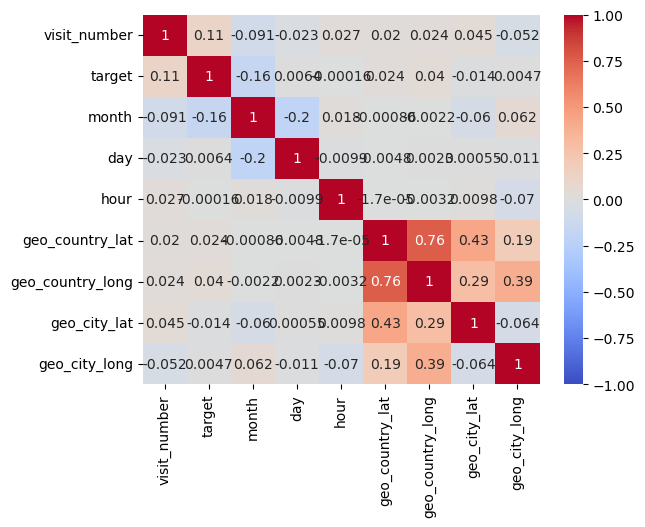

In [130]:
sns.heatmap(df_types.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm');

In [131]:
df_types = df_types.drop(columns=['geo_city_lat', 'geo_city_long', 'date'])

In [132]:
df_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99949 entries, 1383179 to 1849007
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   visit_number              99949 non-null  int32  
 1   utm_source                99949 non-null  object 
 2   utm_medium                99949 non-null  object 
 3   utm_campaign              99949 non-null  object 
 4   utm_adcontent             99949 non-null  object 
 5   device_category           99949 non-null  object 
 6   device_brand              99949 non-null  object 
 7   device_screen_resolution  99949 non-null  object 
 8   device_browser            99949 non-null  object 
 9   geo_country               99949 non-null  object 
 10  geo_city                  99949 non-null  object 
 11  target                    99949 non-null  int32  
 12  month                     99949 non-null  int64  
 13  day                       99949 non-null  int64  
 14

### 2.4.4. Преобразование категориальных данных:

In [134]:
df_types.head()

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,month,day,hour,geo_country_lat,geo_country_long
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,Russia,Surgut,0,12,22,0,64.686314,97.745306
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,Russia,Saratov,0,12,1,22,64.686314,97.745306
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,Russia,Moscow,0,12,7,22,64.686314,97.745306
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),Russia,Krasnodar,0,6,29,13,64.686314,97.745306
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,Russia,Cherkessk,0,12,6,12,64.686314,97.745306


#### OneHotEncoder:

In [136]:
# Удаление ненужных колонок
df_final = df_types.drop(columns=['geo_country', 'geo_city'])
df_final

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,target,month,day,hour,geo_country_lat,geo_country_long
1383179,4,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome,0,12,22,0,64.686314,97.745306
297583,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome,0,12,1,22,64.686314,97.745306
998034,1,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome,0,12,7,22,64.686314,97.745306
229469,1,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app),0,6,29,13,64.686314,97.745306
1247627,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome,0,12,6,12,64.686314,97.745306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848865,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,other,Chrome,1,8,23,7,64.686314,97.745306
1848869,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,1,9,9,13,64.686314,97.745306
1848903,1,bByPQxmDaMXgpHeypKSM,referral,other,other,desktop,other,other,Chrome,1,8,19,18,64.686314,97.745306
1849000,1,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,other,Chrome,1,10,2,2,64.686314,97.745306


In [137]:
# Выбор данных для преобразования
data_1 = df_final[['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand', 'device_screen_resolution', 'device_browser']]
data_1

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser
1383179,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x780,Chrome
297583,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,other,Chrome
998034,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x640,Chrome
229469,other,stories,other,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x812,Safari (in-app)
1247627,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,tablet,other,other,Chrome
...,...,...,...,...,...,...,...,...
1848865,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,other,Chrome
1848869,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari
1848903,bByPQxmDaMXgpHeypKSM,referral,other,other,desktop,other,other,Chrome
1849000,ZpYIoDJMcFzVoPFsHGJL,banner,gecBYcKZCPMcVYdSSzKP,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,other,Chrome


In [138]:
# Преобразование категориальных данных
ohe = OneHotEncoder(sparse=False)
ohe.fit(data_1)
ohe_data = ohe.transform(data_1)
ohe_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [139]:
# Добавление в датасет новых колонок
df_final[ohe.get_feature_names_out()] = ohe_data
df_final.shape

(99949, 92)

In [140]:
# Удаление обработанных колонок
df_final = df_final.drop(columns=['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_category', 'device_brand', 'device_screen_resolution', 'device_browser'])

### 2.4.5. Нормализация данных:

In [141]:
df_final.head()

,visit_number,target,month,day,hour,geo_country_lat,geo_country_long,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_MvfHsxITijuriZxsqZqt,utm_source_QxAxdyPLuQMEcrdZWdWb,...,device_browser_Chrome,device_browser_Edge,device_browser_Firefox,device_browser_Opera,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_UC Browser,device_browser_YaBrowser,device_browser_other
1383179,4,0,12,22,0,64.686314,97.745306,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297583,1,0,12,1,22,64.686314,97.745306,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998034,1,0,12,7,22,64.686314,97.745306,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229469,1,0,6,29,13,64.686314,97.745306,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1247627,1,0,12,6,12,64.686314,97.745306,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### StandardScaler:

In [142]:
# Выбор данных для преобразования
data_2 = df_final[['visit_number', 'month', 'day', 'hour', 'geo_country_lat', 'geo_country_long']]
data_2

,visit_number,month,day,hour,geo_country_lat,geo_country_long
1383179,4,12,22,0,64.686314,97.745306
297583,1,12,1,22,64.686314,97.745306
998034,1,12,7,22,64.686314,97.745306
229469,1,6,29,13,64.686314,97.745306
1247627,1,12,6,12,64.686314,97.745306
...,...,...,...,...,...,...
1848865,1,8,23,7,64.686314,97.745306
1848869,1,9,9,13,64.686314,97.745306
1848903,1,8,19,18,64.686314,97.745306
1849000,1,10,2,2,64.686314,97.745306


In [143]:
# Нормализация данных
std_scaler = StandardScaler()
std_scaler.fit(data_2)
std_scaled = std_scaler.transform(data_2)
std_scaled

array([[ 2.35422636,  1.30890284,  0.56649031, -2.25913425,  0.14564279,
         0.14351433],
       [-0.5785629 ,  1.30890284, -1.81432684,  1.39067939,  0.14564279,
         0.14351433],
       [-0.5785629 ,  1.30890284, -1.13409337,  1.39067939,  0.14564279,
         0.14351433],
       ...,
       [-0.5785629 , -0.4290673 ,  0.22637357,  0.72707691,  0.14564279,
         0.14351433],
       [-0.5785629 ,  0.43991777, -1.70095459, -1.92733301,  0.14564279,
         0.14351433],
       [ 2.35422636, -1.73254491,  1.36009602, -1.26373053,  0.14564279,
         0.14351433]])

In [144]:
# Добавление в датасет новых колонок
df_final[['visit_number_std', 'month_std', 'day_std', 'hour_std', 'geo_country_lat_std', 'geo_country_long_std']] = std_scaled
df_final.shape

(99949, 90)

In [145]:
# Удаление обработанных колонок и сохранение датафрейма для этапа моделирования
columns_for_drop = ['visit_number', 'month', 'day', 'hour', 'geo_country_lat', 'geo_country_long']
df_final = df_final.drop(columns_for_drop, axis=1)
df_final.shape

(99949, 84)

In [146]:
df_final.columns.to_list()

['target',
 'utm_source_BHcvLfOaCWvWTykYqHVe',
 'utm_source_MvfHsxITijuriZxsqZqt',
 'utm_source_QxAxdyPLuQMEcrdZWdWb',
 'utm_source_RmEBuqrriAfAVsLQQmhk',
 'utm_source_ZpYIoDJMcFzVoPFsHGJL',
 'utm_source_aXQzDWsJuGXeBXexNHjc',
 'utm_source_bByPQxmDaMXgpHeypKSM',
 'utm_source_fDLlAcSmythWSCVMvqvL',
 'utm_source_jaSOmLICuBzCFqHfBdRg',
 'utm_source_kjsLglQLzykiRbcDiGcD',
 'utm_source_other',
 'utm_medium_(none)',
 'utm_medium_banner',
 'utm_medium_blogger_channel',
 'utm_medium_cpc',
 'utm_medium_cpm',
 'utm_medium_email',
 'utm_medium_organic',
 'utm_medium_other',
 'utm_medium_push',
 'utm_medium_referral',
 'utm_medium_stories',
 'utm_campaign_FTjNLDyTrXaWYgZymFkV',
 'utm_campaign_LEoPHuyFvzoNfnzGgfcd',
 'utm_campaign_LTuZkdKfxRGVceoWkVyg',
 'utm_campaign_LwJZxKuWmvOhPsaCeRjG',
 'utm_campaign_SgIUDYUKnyWHVowUOqid',
 'utm_campaign_TmThBvoCcwkCZZUWACYq',
 'utm_campaign_XHNUiSKKGTEpSAlaVMFQ',
 'utm_campaign_gecBYcKZCPMcVYdSSzKP',
 'utm_campaign_other',
 'utm_campaign_sbJRYgVfvcnqKJNDDYIr'

# 3. Modelling:

## 3.1. Разделение данных на train и test:

In [147]:
df_prepared = df_final.copy()

x = df_prepared.drop(['target'], axis=1)
y = df_prepared['target']

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 3.2.  Модели без тюнинга параметров:

### 3.2.1. Случайный лес:

In [149]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_rf))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_rf))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_rf))
confusion_matrix(y_test, predicted_test_rf)

Accuracy on train: 0.9680407066491339
Accuracy on test: 0.6048691012172753
ROC-AUC: 0.6049371903731205


array([[8959, 6126],
       [5722, 9178]], dtype=int64)

### 3.2.2. Логистическая регрессия:

In [150]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

predicted_train_logreg = logreg.predict(x_train)
predicted_test_logreg = logreg.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_logreg))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_logreg))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_logreg))
confusion_matrix(y_test, predicted_test_logreg)

Accuracy on train: 0.6237493568120748
Accuracy on test: 0.6236118059029515
ROC-AUC: 0.6238571584288584


array([[8811, 6274],
       [5012, 9888]], dtype=int64)

### 3.2.3. Многослойный персептрон:

In [151]:
mlp = MLPClassifier()
mlp.fit(x_train, y_train)

predicted_train_mlp = mlp.predict(x_train)
predicted_test_mlp = mlp.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_mlp))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_mlp))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_mlp))
confusion_matrix(y_test, predicted_test_mlp)

Accuracy on train: 0.6882253730489967
Accuracy on test: 0.6218442554610638
ROC-AUC: 0.6218255389481974


array([[9426, 5659],
       [5680, 9220]], dtype=int64)

## 3.3. Модели после тюнинга параметров:

### 3.3.1. Случайный лес:

In [152]:
rf_clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=False, 
                                max_depth=100, n_jobs=-1, random_state=12, verbose=True, min_samples_split=2)
rf_clf.fit(x_train, y_train)

predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_rf))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_rf))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_rf))
confusion_matrix(y_test, predicted_test_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


Accuracy on train: 0.9680407066491339
Accuracy on test: 0.5947973986993497
ROC-AUC: 0.5948140737165013


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


array([[8932, 6153],
       [5997, 8903]], dtype=int64)

### 3.3.2. Логистическая регрессия:

In [153]:
logreg = LogisticRegression(C=2, penalty='l2', solver='liblinear', max_iter=1500, random_state=12, class_weight='balanced')
logreg.fit(x_train, y_train)

predicted_train_logreg = logreg.predict(x_train)
predicted_test_logreg = logreg.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_logreg))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_logreg))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_logreg))
confusion_matrix(y_test, predicted_test_logreg)

Accuracy on train: 0.623620719227031
Accuracy on test: 0.6231449057862265
ROC-AUC: 0.6233704867050918


array([[8852, 6233],
       [5067, 9833]], dtype=int64)

### 3.3.3. Многослойный персептрон:

In [154]:
mlp = MLPClassifier(hidden_layer_sizes=(50,), activation = 'logistic')
mlp.fit(x_train, y_train)

predicted_train_mlp = mlp.predict(x_train)
predicted_test_mlp = mlp.predict(x_test)

print('Accuracy on train:', accuracy_score(y_train, predicted_train_mlp))
print('Accuracy on test:', accuracy_score(y_test, predicted_test_mlp))
print('ROC-AUC:', roc_auc_score(y_test, predicted_test_mlp))
confusion_matrix(y_test, predicted_test_mlp)

Accuracy on train: 0.6552655651477903
Accuracy on test: 0.6335501083875271
ROC-AUC: 0.6338164161474241


array([[ 8910,  6175],
       [ 4813, 10087]], dtype=int64)

### 3.3.4. Другие модели:

In [155]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

predicted_train_nb = nb.predict(x_train)
predicted_test_nb = nb.predict(x_test)

print('ROC-AUC:', roc_auc_score(y_test, predicted_test_nb))
confusion_matrix(y_test, predicted_test_nb)

ROC-AUC: 0.5822388678917899


array([[ 4100, 10985],
       [ 1599, 13301]], dtype=int64)

In [156]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

predicted_train_qda = qda.predict(x_train)
predicted_test_qda = qda.predict(x_test)

print('ROC-AUC:', roc_auc_score(y_test, predicted_test_qda))
confusion_matrix(y_test, predicted_test_qda)

ROC-AUC: 0.5558114420965757


array([[ 2513, 12572],
       [  819, 14081]], dtype=int64)

In [157]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)

predicted_train_ada = ada.predict(x_train)
predicted_test_ada = ada.predict(x_test)

print('ROC-AUC:', roc_auc_score(y_test, predicted_test_ada))
confusion_matrix(y_test, predicted_test_ada)

ROC-AUC: 0.6169734368778266


array([[8822, 6263],
       [5228, 9672]], dtype=int64)

In [158]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(3)
knc.fit(x_train, y_train)

predicted_train_knc = knc.predict(x_train)
predicted_test_knc = knc.predict(x_test)

print('ROC-AUC:', roc_auc_score(y_test, predicted_test_knc))
confusion_matrix(y_test, predicted_test_knc)

ROC-AUC: 0.588005029664118


array([[8680, 6405],
       [5951, 8949]], dtype=int64)

## 3.4. Кросс-валидация на тренировочной выборке:

### 3.4.1. Случайный лес:

In [159]:
cv_score_rf_clf = cross_val_score(rf_clf, x_train, y_train, cv=5, scoring='roc_auc')
cv_score_rf_clf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]:

array([0.63212201, 0.62609724, 0.63286785, 0.63095766, 0.62674839])

In [160]:
cv_score_rf_clf.mean(), cv_score_rf_clf.std()

(0.6297586285140777, 0.0027984928514218016)

### 3.4.2.  Логистическая регрессия:

In [161]:
cv_score_logreg = cross_val_score(logreg, x_train, y_train, cv=5, scoring='roc_auc')
cv_score_logreg

array([0.67178305, 0.67229803, 0.67319239, 0.6672609 , 0.66582982])

In [162]:
cv_score_logreg.mean(), cv_score_logreg.std()

(0.6700728394599706, 0.0029501893910053346)

### 3.4.3. Многослойный персептрон:

In [163]:
cv_score_mlp = cross_val_score(mlp, x_train, y_train, cv=5, scoring='roc_auc')
cv_score_mlp

array([0.69111924, 0.68983339, 0.69118752, 0.68959918, 0.6852275 ])

In [164]:
cv_score_mlp.mean(), cv_score_mlp.std()

(0.6893933654435334, 0.0021811941752165735)

# 4. Results:

## 4.1. Лучшая модель по результатам кросс-валидации:

In [165]:
mlp.fit(x, y)

predicted_mlp = mlp.predict(x)

print(accuracy_score(y, predicted_mlp))
confusion_matrix(y, predicted_mlp)

0.6563947613282775


array([[29641, 20308],
       [14035, 35965]], dtype=int64)

In [166]:
filename = 'model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(mlp, file)